<a href="https://colab.research.google.com/github/wherediddavidgo/multitemporal_RSSA/blob/main/stac_gage_ew_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install dataretrieval
!pip install pygris
import pygris
import glob
import os
from dataretrieval import nwis as nwis
from dataretrieval import wqp
from google.colab import drive
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import geopandas as gpd
import datetime
from tqdm import tqdm
from shapely import Point
from scipy.stats import linregress

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.4 MB/s eta 0:00:00


In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


Load gages for 34 gage validation

In [3]:
# gage_pts_1 = gpd.read_file('/content/drive/MyDrive/effwidth_results/gage_sites/val_gages_2.shp')[['iindex', 'site_no']]
gage_pts = gpd.read_file('/content/drive/MyDrive/effwidth_results/gage_sites/val_gages_3.shp')[['site_no', 'iindex', 'geometry']]
gage_pts = gage_pts.loc[gage_pts.site_no != '06794500'] # all P quality code
gage_pts = gage_pts.merge(gpd.read_file('/content/drive/MyDrive/river_tinder_assets/gage_sites/gage_circles_3x_20250927.shp')[['iindex', 'riv_length']], on='iindex')
gage_list = gage_pts.site_no.tolist()
gage_pts

,site_no,iindex,geometry,riv_length
0,06764880,225467,POINT (-101.57667 41.12611),172.516752
1,06775900,75941,POINT (-100.52528 41.77861),92.934030
2,06775500,77597,POINT (-100.09953 41.83092),74.194767
3,06770200,217337,POINT (-99.08611 40.65806),1399.403363
4,06767970,245153,POINT (-99.56796 40.67684),923.997749
5,06768000,244511,POINT (-99.54056 40.6825),907.346015
6,06784000,259030,POINT (-98.74056 41.0325),216.935252
7,06781900,210361,POINT (-99.70861 41.19278),106.830719
8,06785000,157059,POINT (-98.44611 41.2035),574.579112
9,06790500,168277,POINT (-98.44924 41.26335),483.536907


Discharge

In [4]:
# sites = ['06620000', '06775900', '06800000', '06800500', '06801000', '06805500']
sites = gage_list

# first and last dates same as for in situ widths
# start = str(isw.index.sortlevel(1)[0][0][1])
# end = str(isw.index.sortlevel(1)[0][-1][1])
start = '2018-01-01'
end = '2024-12-31'

Q = nwis.get_record(sites, service='dv', start=start, end=end).reset_index()
Q['date'] = Q.datetime.dt.date
Q = Q[['site_no', 'date', '00060_Mean', '00060_Mean_cd']]
Q['00060_Mean'] = Q['00060_Mean'] * (3.28 ** -3)
# Q['00065_Mean'] = Q['00065_Mean'] * (3.28 ** -1)
Q = Q.rename(columns={'00060_Mean': 'Q_cms', '00060_Mean_cd': 'Q_cd'})
# Q = Q.loc[Q.Q_cd == 'A']
# Q['Q_percentile'] = Q.groupby('site_no')['Q_cms'].rank(pct=True)
Q = Q.set_index(['site_no', 'date'])
Q

Q_cms  Q_cd
site_no  date                       
06620000 2018-01-01   3.740696  A, e
         2018-01-02   3.457310  A, e
         2018-01-03   3.343955  A, e
         2018-01-04   3.400633  A, e
         2018-01-05   3.513987  A, e
...                        ...   ...
06800500 2024-12-27  30.038921     A
         2024-12-28  32.306010     A
         2024-12-29  33.439554     A
         2024-12-30  35.990028     A
         2024-12-31  36.556801     A

[82007 rows x 2 columns]

Load in effective width\
See stac_processing_download.ipynb

In [5]:
width_dfs = []
for year in [2018, 2019, 2020, 2021, 2022, 2023, 2024]:
    # width_dfs.append(pd.read_csv(f'/content/drive/MyDrive/effwidth_results/gage_sites/gage_effwidths_{year}_20250911_nond.csv'))
    width_dfs.append(pd.read_csv(f'/content/drive/MyDrive/effwidth_results/gage_sites/effwidths_{year}_g2_20250921.csv'))
    width_dfs.append(pd.read_csv(f'/content/drive/MyDrive/effwidth_results/gage_sites/effwidths_{year}_gx_20250927.csv'))

allwidths = pd.concat(width_dfs)

allwidths['mgrs'] = allwidths.apply(lambda x: x['img_id'].split('_')[1], axis=1)
allwidths['date'] = allwidths.apply(lambda x: datetime.date(int(x['img_id'][10:14]), int(x['img_id'][14:16]), int(x['img_id'][16:18])), axis=1)
allwidths['version'] = allwidths.apply(lambda x: x['img_id'].split('_')[3], axis=1)

allwidths = allwidths.loc[(allwidths.n_valid == allwidths.n_pixels) & (allwidths.n_valid > -999)]


allwidths

,Unnamed: 0,img_id,iindex,n_pixels,n_valid,n_river,n_cloud,n_snow,n_cloudriver,n_edge,n_edgeriver,mgrs,date,version
0,0,S2A_13TGF_20180623_1_L2A,225467,162,162,69,0,0,0,43,9,13TGF,2018-06-23,1
1,1,S2A_14TQM_20181015_0_L2A,120725,164,164,27,4,0,4,43,4,14TQM,2018-10-15,0
2,2,S2B_13TCG_20180611_1_L2A,78261,72,72,13,0,0,0,30,4,13TCG,2018-06-11,1
3,3,S2B_13TCG_20180611_1_L2A,92120,1225,1225,152,85,0,32,115,7,13TCG,2018-06-11,1
4,4,S2B_14TNM_20180622_1_L2A,11750,496,496,72,220,0,57,74,3,14TNM,2018-06-22,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,444,S2A_14TML_20240310_0_L2A,244511,5647,5647,1326,0,0,0,243,28,14TML,2024-03-10,0
445,445,S2A_14TML_20240310_0_L2A,245153,5570,5570,767,0,0,0,240,20,14TML,2024-03-10,0
447,447,S2A_14TPM_20241219_0_L2A,82494,1454,1454,326,0,28,0,124,19,14TPM,2024-12-19,0
448,448,S2A_14TQL_20241020_0_L2A,246043,763,763,196,0,0,0,90,12,14TQL,2024-10-20,0


Join widths and gage ids

In [6]:
allwidths = pd.merge(allwidths, gage_pts, how='left', on='iindex')
allwidths = allwidths.rename(columns={'gage_id': 'site_no'})
allwidths

,Unnamed: 0,img_id,iindex,n_pixels,n_valid,n_river,n_cloud,n_snow,n_cloudriver,n_edge,n_edgeriver,mgrs,date,version,site_no,geometry,riv_length
0,0,S2A_13TGF_20180623_1_L2A,225467,162,162,69,0,0,0,43,9,13TGF,2018-06-23,1,06764880,POINT (-101.57667 41.12611),172.516752
1,1,S2A_14TQM_20181015_0_L2A,120725,164,164,27,4,0,4,43,4,14TQM,2018-10-15,0,06800000,POINT (-96.54083 41.56117),148.276448
2,2,S2B_13TCG_20180611_1_L2A,78261,72,72,13,0,0,0,30,4,13TCG,2018-06-11,1,06635000,POINT (-106.51314 42.00967),93.794831
3,3,S2B_13TCG_20180611_1_L2A,92120,1225,1225,152,85,0,32,115,7,13TCG,2018-06-11,1,06630000,POINT (-107.0576 41.87217),480.468419
4,4,S2B_14TNM_20180622_1_L2A,11750,496,496,72,220,0,57,74,3,14TNM,2018-06-22,1,06797500,POINT (-98.33936 42.26844),286.834439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14825,444,S2A_14TML_20240310_0_L2A,244511,5647,5647,1326,0,0,0,243,28,14TML,2024-03-10,0,06768000,POINT (-99.54056 40.6825),907.346015
14826,445,S2A_14TML_20240310_0_L2A,245153,5570,5570,767,0,0,0,240,20,14TML,2024-03-10,0,06767970,POINT (-99.56796 40.67684),923.997749
14827,447,S2A_14TPM_20241219_0_L2A,82494,1454,1454,326,0,28,0,124,19,14TPM,2024-12-19,0,06799350,POINT (-96.72753 41.83944),472.125623
14828,448,S2A_14TQL_20241020_0_L2A,246043,763,763,196,0,0,0,90,12,14TQL,2024-10-20,0,06800500,POINT (-96.28389 41.29333),372.624481


Calculate effective width and fractions of cloud and snow

In [7]:
allwidths['sat_width_m'] = allwidths.n_river * 100 / allwidths.riv_length
allwidths['fraction_cloud'] = allwidths.n_cloud / allwidths.n_pixels
allwidths['fraction_snow'] = allwidths.n_snow / allwidths.n_pixels
allwidths['fraction_edgeriver'] = allwidths.n_edgeriver / allwidths.n_edge
allwidths = allwidths.set_index(['site_no', 'date'])
allwidths

,,Unnamed: 0,img_id,iindex,n_pixels,n_valid,n_river,n_cloud,n_snow,n_cloudriver,n_edge,n_edgeriver,mgrs,version,geometry,riv_length,sat_width_m,fraction_cloud,fraction_snow,fraction_edgeriver
site_no,date,,,,,,,,,,,,,,,,,,,
06764880,2018-06-23,0,S2A_13TGF_20180623_1_L2A,225467,162,162,69,0,0,0,43,9,13TGF,1,POINT (-101.57667 41.12611),172.516752,39.996116,0.000000,0.000000,0.209302
06800000,2018-10-15,1,S2A_14TQM_20181015_0_L2A,120725,164,164,27,4,0,4,43,4,14TQM,0,POINT (-96.54083 41.56117),148.276448,18.209230,0.024390,0.000000,0.093023
06635000,2018-06-11,2,S2B_13TCG_20180611_1_L2A,78261,72,72,13,0,0,0,30,4,13TCG,1,POINT (-106.51314 42.00967),93.794831,13.860039,0.000000,0.000000,0.133333
06630000,2018-06-11,3,S2B_13TCG_20180611_1_L2A,92120,1225,1225,152,85,0,32,115,7,13TCG,1,POINT (-107.0576 41.87217),480.468419,31.635794,0.069388,0.000000,0.060870
06797500,2018-06-22,4,S2B_14TNM_20180622_1_L2A,11750,496,496,72,220,0,57,74,3,14TNM,1,POINT (-98.33936 42.26844),286.834439,25.101588,0.443548,0.000000,0.040541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
06768000,2024-03-10,444,S2A_14TML_20240310_0_L2A,244511,5647,5647,1326,0,0,0,243,28,14TML,0,POINT (-99.54056 40.6825),907.346015,146.140500,0.000000,0.000000,0.115226
06767970,2024-03-10,445,S2A_14TML_20240310_0_L2A,245153,5570,5570,767,0,0,0,240,20,14TML,0,POINT (-99.56796 40.67684),923.997749,83.008860,0.000000,0.000000,0.083333
06799350,2024-12-19,447,S2A_14TPM_20241219_0_L2A,82494,1454,1454,326,0,28,0,124,19,14TPM,0,POINT (-96.72753 41.83944),472.125623,69.049419,0.000000,0.019257,0.153226


In [8]:
widths_filtered = allwidths.copy()
widths_filtered = widths_filtered.loc[widths_filtered.fraction_cloud < 0.2]
print(len(widths_filtered))
widths_filtered = widths_filtered.loc[widths_filtered.fraction_snow < 0.2]
print(len(widths_filtered))
# widths_filtered = widths_filtered.loc[(widths_filtered.n_cloud - widths_filtered.n_cloudriver / widths_filtered.n_valid) < 0.4]
print(len(widths_filtered))
# widths_filtered = widths_filtered.loc[widths_filtered.fraction_edgeriver < 0.3]
print(len(widths_filtered))
widths_filtered = widths_filtered.loc[widths_filtered.n_edge < widths_filtered.n_river]
print(len(widths_filtered))


widths_filtered['width_percentile'] = widths_filtered.groupby('site_no')['sat_width_m'].rank(pct=True)
# widths_filtered

13364
11730
11730
11730
6653


Filter Q for quality, calculate percentiles

In [71]:
Q_filtered = Q.copy()
Q_filtered = Q_filtered.loc[Q_filtered.Q_cd == 'A']
Q_filtered = Q_filtered.loc[Q_filtered.Q_cms > 0]

Q_filtered['Q_percentile'] = Q_filtered.groupby('site_no')['Q_cms'].rank(pct=True)
Q_filtered = Q_filtered.loc[Q_filtered.index.get_level_values('site_no')!= '06764880']

Q_filtered
# print(len(Q_filtered))

Q_cms Q_cd  Q_percentile
site_no  date                                    
06620000 2018-03-24   9.323401    A      0.591856
         2018-03-25  12.128923    A      0.648990
         2018-03-26  12.355632    A      0.655303
         2018-03-27  11.023717    A      0.630682
         2018-03-28   9.748480    A      0.602273
...                        ...  ...           ...
06800500 2024-12-27  30.038921    A      0.274314
         2024-12-28  32.306010    A      0.312968
         2024-12-29  33.439554    A      0.327681
         2024-12-30  35.990028    A      0.363092
         2024-12-31  36.556801    A      0.369825

[65627 rows x 3 columns]

Join gage discharge and sat width on date

In [72]:
wQ = Q_filtered.join(widths_filtered, how='inner').reset_index()
wQ = wQ.set_index(['site_no', 'date'])
wQ

Q_cms Q_cd  Q_percentile  Unnamed: 0  \
site_no  date                                                   
06620000 2018-04-27   9.861835    A      0.604798         594   
         2018-05-17  22.529191    A      0.800189         156   
         2018-06-06  19.241913    A      0.758523        1623   
         2018-06-11  15.727926    A      0.703914         645   
         2018-06-21  16.634761    A      0.720960        1442   
...                        ...  ...           ...         ...   
06800500 2024-12-09  28.905377    A      0.257606         373   
         2024-12-19  26.524934    A      0.217955          61   
         2024-12-19  26.524934    A      0.217955         433   
         2024-12-22  22.954270    A      0.169077         233   
         2024-12-22  22.954270    A      0.169077         331   

                                       img_id  iindex  n_pixels  n_valid  \
site_no  date                                                              
06620000 2018-04-27  S2A_13TCF_20180427_0_L2A   41900       163      163   
         2018-05-17  S2A_13TCF_20180517_1_L2A   41900       163      163   
         2018-06-06  S2A_13TCF_20180606_0_L2A   41900       163      163   
         2018-06-11  S2B_13TCF_20180611_1_L2A   41900       163      163   
         2018-06-21  S2B_13TCF_20180621_1_L2A   41900       163      163   
...                                       ...     ...       ...      ...   
06800500 2024-12-09  S2A_15TTF_20241209_0_L2A  246043       760      760   
         2024-12-19  S2A_15TTF_20241219_0_L2A  246043       760      760   
         2024-12-19  S2A_14TQL_20241219_0_L2A  246043       763      763   
         2024-12-22  S2A_14TQL_20241222_0_L2A  246043       763      763   
         2024-12-22  S2A_15TTF_20241222_0_L2A  246043       760      760   

                     n_river  n_cloud  ...  n_edgeriver   mgrs  version  \
site_no  date                          ...                                
06620000 2018-04-27       46       12  ...            4  13TCF        0   
         2018-05-17       46       20  ...            4  13TCF        1   
         2018-06-06       57        0  ...            6  13TCF        0   
         2018-06-11       45       13  ...            6  13TCF        1   
         2018-06-21       46       17  ...            6  13TCF        1   
...                      ...      ...  ...          ...    ...      ...   
06800500 2024-12-09      206        0  ...           15  15TTF        0   
         2024-12-19      185        0  ...           13  15TTF        0   
         2024-12-19      188        0  ...           12  14TQL        0   
         2024-12-22      196        0  ...           13  14TQL        0   
         2024-12-22      196        0  ...           15  15TTF        0   

                                        geometry  riv_length sat_width_m  \
site_no  date                                                              
06620000 2018-04-27  POINT (-106.33919 40.93664)  140.711919   32.690905   
         2018-05-17  POINT (-106.33919 40.93664)  140.711919   32.690905   
         2018-06-06  POINT (-106.33919 40.93664)  140.711919   40.508296   
         2018-06-11  POINT (-106.33919 40.93664)  140.711919   31.980233   
         2018-06-21  POINT (-106.33919 40.93664)  140.711919   32.690905   
...                                          ...         ...         ...   
06800500 2024-12-09   POINT (-96.28389 41.29333)  372.624481   55.283539   
         2024-12-19   POINT (-96.28389 41.29333)  372.624481   49.647838   
         2024-12-19   POINT (-96.28389 41.29333)  372.624481   50.452938   
         2024-12-22   POINT (-96.28389 41.29333)  372.624481   52.599872   
         2024-12-22   POINT (-96.28389 41.29333)  372.624481   52.599872   

                    fraction_cloud  fraction_snow  fraction_edgeriver  \
site_no  date                                                           
06620000 2018-04-27       0.073620            0.0            0.090909   
      

In [73]:

bins10 = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
bins5 = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
bins20 = np.arange(0, 1.05, 0.05).tolist()
bins100 = np.arange(0, 1.01, 0.01)
bins4 = np.arange(0, 1.25, 0.25).tolist()
bins = bins4
bins50 = np.arange(0, (1 + (1 / 50)), (1 / 50))
bins25 = np.arange(0, (1 + (1 / 25)), (1 / 25))

all_allbins = []

for bins in [bins5, bins10, bins20, bins25, bins50, bins100]:
    # wQ['width_percentile_bin'] = wQ.groupby('site_no')['width_percentile'].transform(
    #     lambda x: pd.cut(x, bins=bins, labels=False)
    # )
    wQ['Q_percentile_bin'] = wQ.groupby('site_no')['Q_percentile'].transform(
        lambda x: pd.cut(x, bins=bins, labels=False)
    )

    # Qbins = wQ.groupby(['Q_percentile_bin']).agg(
    #     mean_bin_Q = ('Q_cms', 'mean'),
    #     median_bin_Q = ('Q_cms', 'median')
    # ).rename_axis(index={'Q_percentile_bin': 'percentile_bin'})

    # wbins = wQ.groupby(['width_percentile_bin']).agg(
    #     mean_bin_w = ('sat_width_m', 'mean'),
    #     median_bin_w = ('sat_width_m', 'median')
    # ).rename_axis(index={'width_percentile_bin': 'percentile_bin'})

    # allbins = Qbins.join(wbins)

    all_allbins.append(wQ)

binnos = [5, 10, 20, 25, 50, 100]


In [74]:
wQ['Q_percentile_bin'] = wQ.groupby('site_no')['Q_percentile'].transform(
    lambda x: pd.cut(x, bins=bins5, labels=False)
)
wQ

Q_cms Q_cd  Q_percentile  Unnamed: 0  \
site_no  date                                                   
06620000 2018-04-27   9.861835    A      0.604798         594   
         2018-05-17  22.529191    A      0.800189         156   
         2018-06-06  19.241913    A      0.758523        1623   
         2018-06-11  15.727926    A      0.703914         645   
         2018-06-21  16.634761    A      0.720960        1442   
...                        ...  ...           ...         ...   
06800500 2024-12-09  28.905377    A      0.257606         373   
         2024-12-19  26.524934    A      0.217955          61   
         2024-12-19  26.524934    A      0.217955         433   
         2024-12-22  22.954270    A      0.169077         233   
         2024-12-22  22.954270    A      0.169077         331   

                                       img_id  iindex  n_pixels  n_valid  \
site_no  date                                                              
06620000 2018-04-27  S2A_13TCF_20180427_0_L2A   41900       163      163   
         2018-05-17  S2A_13TCF_20180517_1_L2A   41900       163      163   
         2018-06-06  S2A_13TCF_20180606_0_L2A   41900       163      163   
         2018-06-11  S2B_13TCF_20180611_1_L2A   41900       163      163   
         2018-06-21  S2B_13TCF_20180621_1_L2A   41900       163      163   
...                                       ...     ...       ...      ...   
06800500 2024-12-09  S2A_15TTF_20241209_0_L2A  246043       760      760   
         2024-12-19  S2A_15TTF_20241219_0_L2A  246043       760      760   
         2024-12-19  S2A_14TQL_20241219_0_L2A  246043       763      763   
         2024-12-22  S2A_14TQL_20241222_0_L2A  246043       763      763   
         2024-12-22  S2A_15TTF_20241222_0_L2A  246043       760      760   

                     n_river  n_cloud  ...   mgrs  version  \
site_no  date                          ...                   
06620000 2018-04-27       46       12  ...  13TCF        0   
         2018-05-17       46       20  ...  13TCF        1   
         2018-06-06       57        0  ...  13TCF        0   
         2018-06-11       45       13  ...  13TCF        1   
         2018-06-21       46       17  ...  13TCF        1   
...                      ...      ...  ...    ...      ...   
06800500 2024-12-09      206        0  ...  15TTF        0   
         2024-12-19      185        0  ...  15TTF        0   
         2024-12-19      188        0  ...  14TQL        0   
         2024-12-22      196        0  ...  14TQL        0   
         2024-12-22      196        0  ...  15TTF        0   

                                        geometry  riv_length sat_width_m  \
site_no  date                                                              
06620000 2018-04-27  POINT (-106.33919 40.93664)  140.711919   32.690905   
         2018-05-17  POINT (-106.33919 40.93664)  140.711919   32.690905   
         2018-06-06  POINT (-106.33919 40.93664)  140.711919   40.508296   
         2018-06-11  POINT (-106.33919 40.93664)  140.711919   31.980233   
         2018-06-21  POINT (-106.33919 40.93664)  140.711919   32.690905   
...                                          ...         ...         ...   
06800500 2024-12-09   POINT (-96.28389 41.29333)  372.624481   55.283539   
         2024-12-19   POINT (-96.28389 41.29333)  372.624481   49.647838   
         2024-12-19   POINT (-96.28389 41.29333)  372.624481   50.452938   
         2024-12-22   POINT (-96.28389 41.29333)  372.624481   52.599872   
         2024-12-22   POINT (-96.28389 41.29333)  372.624481   52.599872   

                    fraction_cloud fraction_snow  fraction_edgeriver  \
site_no  date                                                          
06620000 2018-04-27       0.073620           0.0            0.090909   
         2018-05-17       0.122699           0.0            0.090909   
         2018-06-06       0.000000           0.0            0.136364   
         2018-06-11       0.079755

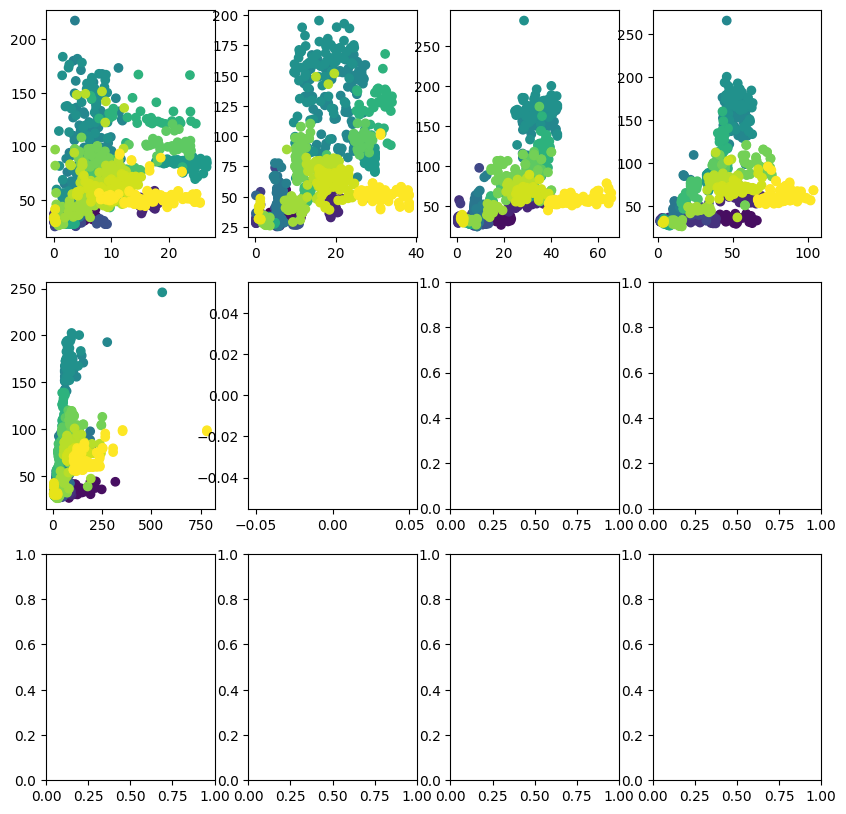

In [82]:
cby_site_no = wQ.index.get_level_values('site_no').to_series().astype('category').cat.codes
num_categories = len(cby_site_no.unique())
cmap = plt.get_cmap('viridis', num_categories)
colors = [cmap(i) for i in cby_site_no]

bigdf = wQ
bigdf['color'] = colors
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(10, 10))

i = 0
for bin in bins5:
    # pc = pcs[i]
    ax = axs.flatten()[i]
    df = bigdf.loc[bigdf.Q_percentile_bin == i]

    ax.scatter(df.Q_cms, df.sat_width_m, c=df.color)
    # ax.set_xscale('log')
    # ax.set_yscale('log')
    i += 1

In [79]:
len(wQ)

5160

0
1
2
3
4
5


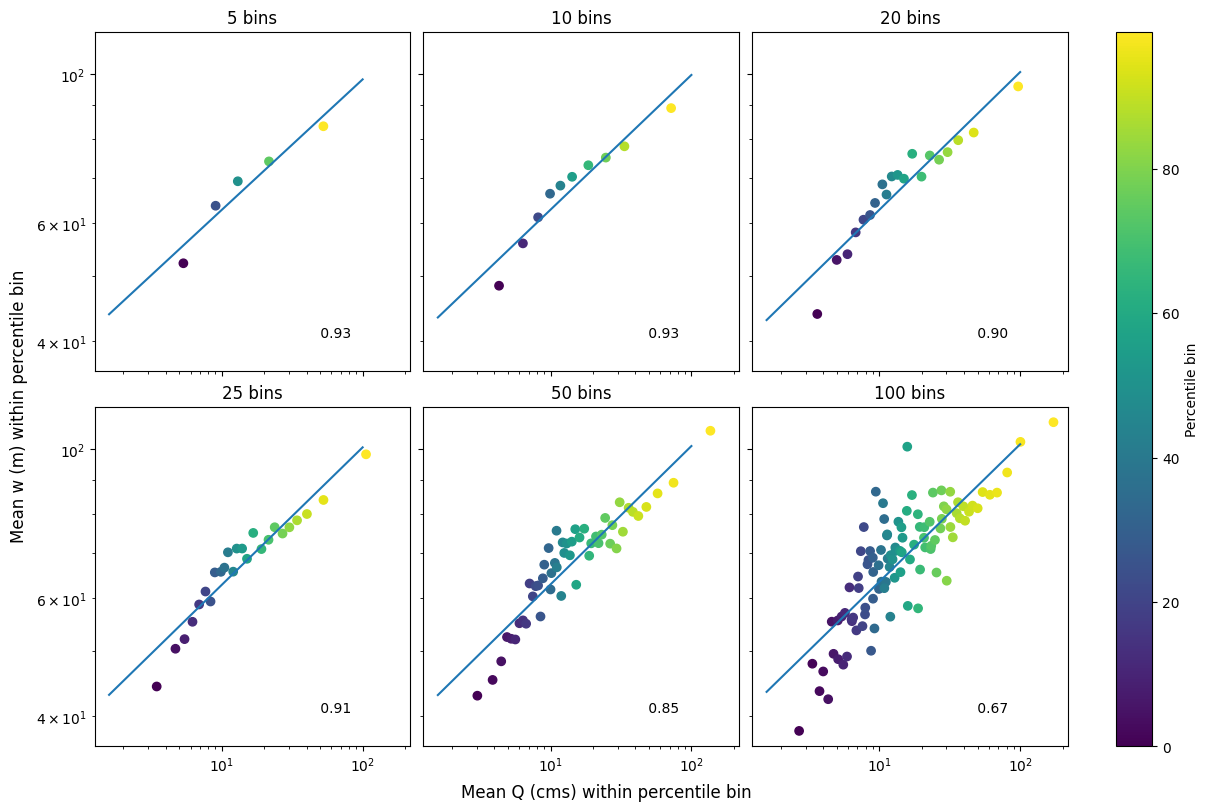

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=3, constrained_layout=True, sharex=True, sharey=True, figsize=(12, 8))
fig.supxlabel('Mean Q (cms) within percentile bin')
fig.supylabel('Mean w (m) within percentile bin')
lrstats = []

for i in range(len(all_allbins)):
    print(i)
    allbins = all_allbins[i]
    color = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'brown']
    ax = axs.flatten()[i]
    dat = ax.scatter(allbins.mean_bin_Q, allbins.mean_bin_w, c=allbins.index)
    # ax.scatter(allbins.median_bin_Q, allbins.median_bin_w, c=color[i], marker='^', alpha=0.5)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(f'{binnos[i]} bins')


    lrs = linregress(np.log10(allbins.mean_bin_Q), np.log10(allbins.mean_bin_w))

    lrstats.append(lrs)

    b = lrs[0]
    loga = lrs[1]
    a = 10 ** loga
    r = lrs[2]

    regress_x = np.logspace(0.2, 2)
    ax.plot(regress_x, (regress_x ** b) * a)
    ax.text(0.7, 0.1, f'{r ** 2: .2f}', transform=ax.transAxes)


cbar = fig.colorbar(dat, ax=axs, orientation='vertical', fraction=0.05, pad=0.05)
cbar.set_label('Percentile bin')

In [ ]:
lrstats = pd.DataFrame(lrstats)
lrstats['n_bins'] = [5, 10, 20, 25, 50, 100]
lrstats

,slope,intercept,rvalue,pvalue,stderr,n_bins
0,0.194663,1.603145,0.964429,8.010362e-03,0.030805,5
1,0.200989,1.597086,0.961907,8.797451e-06,0.020195,10
2,0.205545,1.592299,0.949488,1.691665e-10,0.016012,20
3,0.205115,1.592885,0.952545,2.263867e-13,0.013667,25
4,0.206367,1.592317,0.921662,2.272598e-21,0.012539,50
5,0.205204,1.597309,0.818044,2.813784e-25,0.014574,100


In [ ]:
100 / 25

4.0

Text(0.5, 0.98, 'S2 width vs gage discharge')

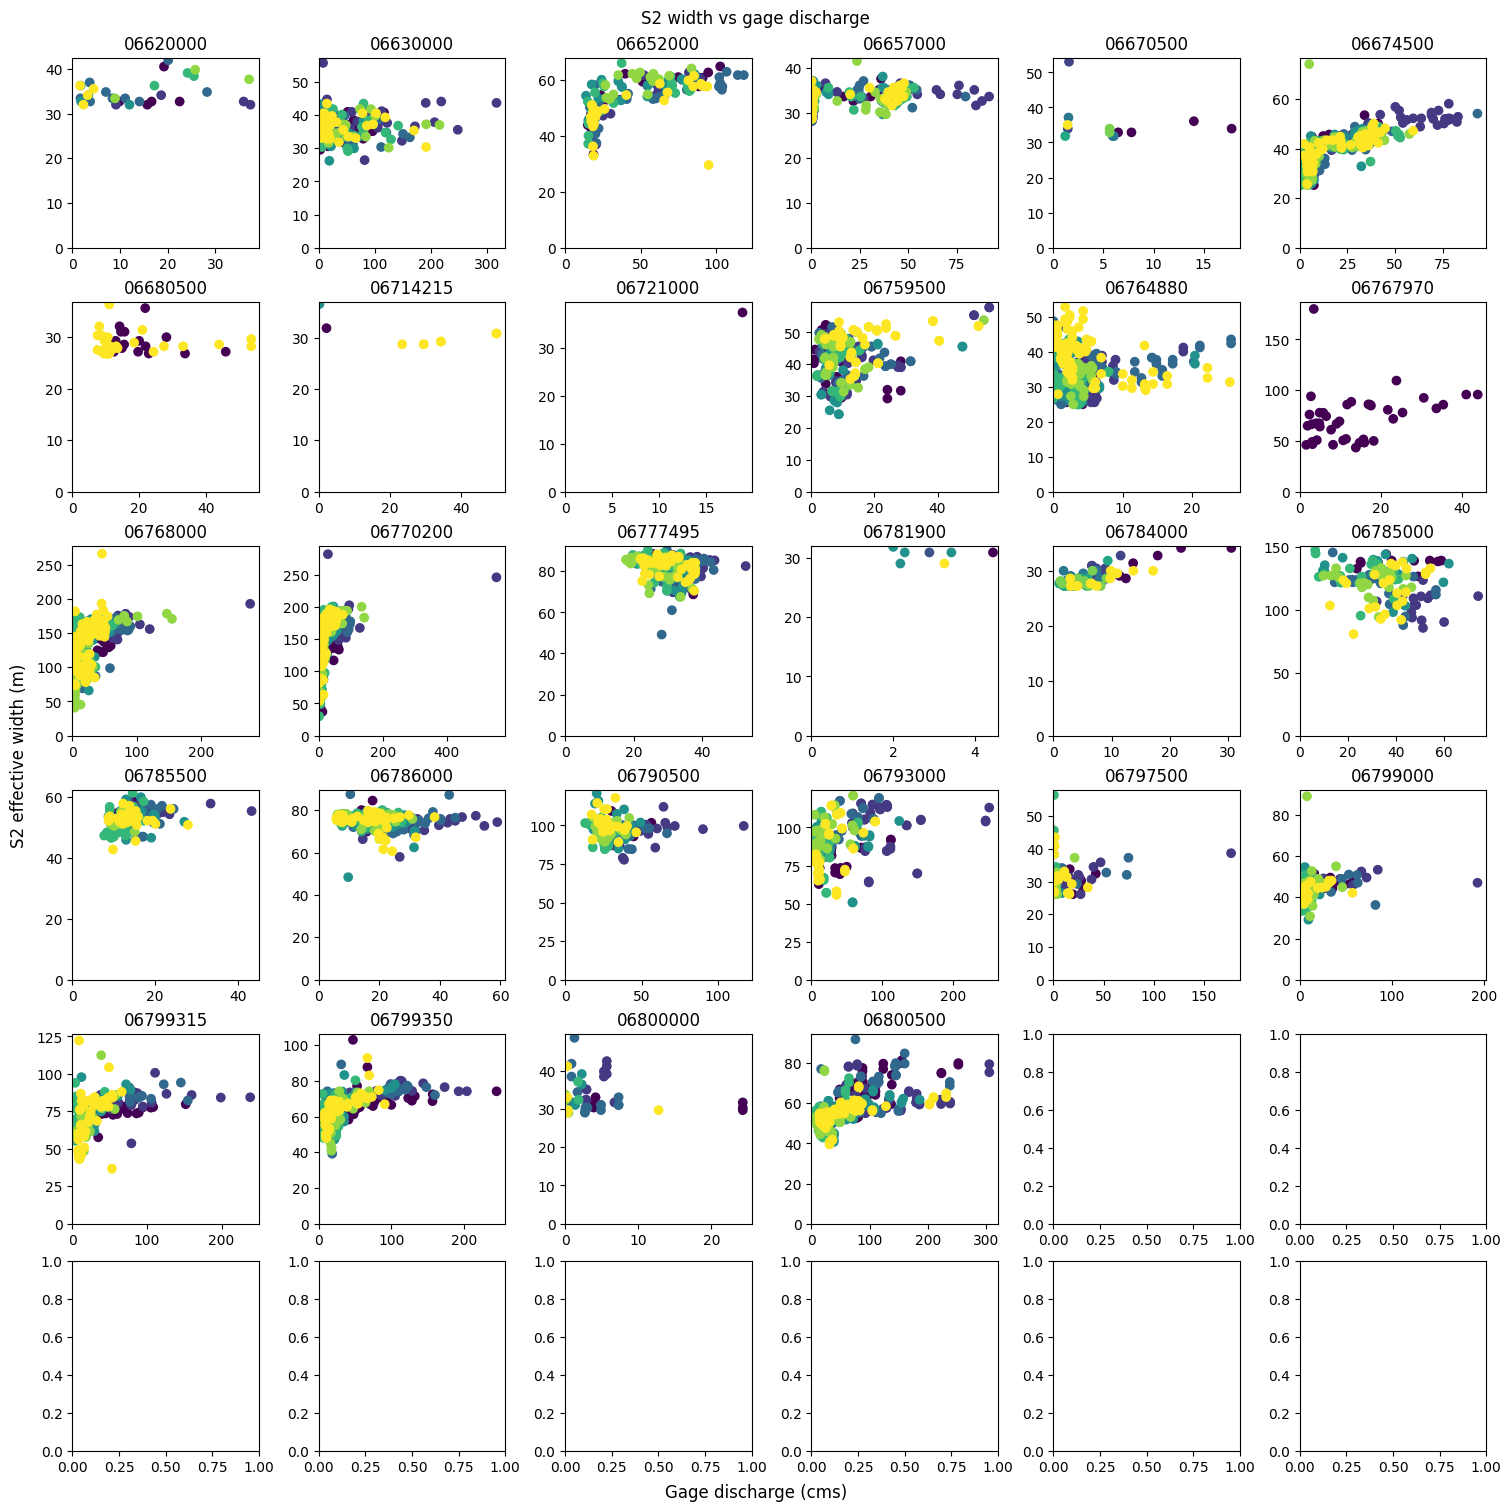

In [62]:
t = wQ

t = t.loc[t.fraction_edgeriver < 0.25]

t = t.reset_index()
t.date = pd.to_datetime(t.date)
# t['month'] = t.date.dt.month
t['year'] = t.date.dt.year

fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(15, 15), constrained_layout=True)
p = 0
for g, df in t.groupby('site_no'):


    ax = axs.flatten()[p]
    # df1 = df.loc[df.Q_cd == 'A']
    # df2 = df.loc[df.Q_cd != 'A']
    ax.scatter(df.Q_cms, df.sat_width_m, c=df.year)
    # dat2 = ax.scatter(df.median_Q, df.median_w, c='blue')
    # dat2 = ax.scatter(df2.Q_cms, df2.sat_width_m, c='red')
    # ax.set_xscale('log')
    # ax.set_yscale('log')
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)
    ax.set_title(g)
    p += 1

fig.supxlabel('Gage discharge (cms)')
fig.supylabel('S2 effective width (m)')
fig.suptitle('S2 width vs gage discharge')

# fig.colorbar(dat1, ax=axs, orientation='vertical', fraction=0.05, pad=0.05)


In [54]:
wQ

Q_cms Q_cd  Q_percentile  Unnamed: 0  \
site_no  date                                                   
06620000 2018-04-27   9.861835    A      0.604798         594   
         2018-05-17  22.529191    A      0.800189         156   
         2018-06-06  19.241913    A      0.758523        1623   
         2018-06-11  15.727926    A      0.703914         645   
         2018-06-21  16.634761    A      0.720960        1442   
...                        ...  ...           ...         ...   
06800500 2024-12-09  28.905377    A      0.257606         373   
         2024-12-19  26.524934    A      0.217955          61   
         2024-12-19  26.524934    A      0.217955         433   
         2024-12-22  22.954270    A      0.169077         233   
         2024-12-22  22.954270    A      0.169077         331   

                                       img_id  iindex  n_pixels  n_valid  \
site_no  date                                                              
06620000 2018-04-27  S2A_13TCF_20180427_0_L2A   41900       163      163   
         2018-05-17  S2A_13TCF_20180517_1_L2A   41900       163      163   
         2018-06-06  S2A_13TCF_20180606_0_L2A   41900       163      163   
         2018-06-11  S2B_13TCF_20180611_1_L2A   41900       163      163   
         2018-06-21  S2B_13TCF_20180621_1_L2A   41900       163      163   
...                                       ...     ...       ...      ...   
06800500 2024-12-09  S2A_15TTF_20241209_0_L2A  246043       760      760   
         2024-12-19  S2A_15TTF_20241219_0_L2A  246043       760      760   
         2024-12-19  S2A_14TQL_20241219_0_L2A  246043       763      763   
         2024-12-22  S2A_14TQL_20241222_0_L2A  246043       763      763   
         2024-12-22  S2A_15TTF_20241222_0_L2A  246043       760      760   

                     n_river  n_cloud  ...   mgrs  version  \
site_no  date                          ...                   
06620000 2018-04-27       46       12  ...  13TCF        0   
         2018-05-17       46       20  ...  13TCF        1   
         2018-06-06       57        0  ...  13TCF        0   
         2018-06-11       45       13  ...  13TCF        1   
         2018-06-21       46       17  ...  13TCF        1   
...                      ...      ...  ...    ...      ...   
06800500 2024-12-09      206        0  ...  15TTF        0   
         2024-12-19      185        0  ...  15TTF        0   
         2024-12-19      188        0  ...  14TQL        0   
         2024-12-22      196        0  ...  14TQL        0   
         2024-12-22      196        0  ...  15TTF        0   

                                        geometry  riv_length sat_width_m  \
site_no  date                                                              
06620000 2018-04-27  POINT (-106.33919 40.93664)  140.711919   32.690905   
         2018-05-17  POINT (-106.33919 40.93664)  140.711919   32.690905   
         2018-06-06  POINT (-106.33919 40.93664)  140.711919   40.508296   
         2018-06-11  POINT (-106.33919 40.93664)  140.711919   31.980233   
         2018-06-21  POINT (-106.33919 40.93664)  140.711919   32.690905   
...                                          ...         ...         ...   
06800500 2024-12-09   POINT (-96.28389 41.29333)  372.624481   55.283539   
         2024-12-19   POINT (-96.28389 41.29333)  372.624481   49.647838   
         2024-12-19   POINT (-96.28389 41.29333)  372.624481   50.452938   
         2024-12-22   POINT (-96.28389 41.29333)  372.624481   52.599872   
         2024-12-22   POINT (-96.28389 41.29333)  372.624481   52.599872   

                    fraction_cloud fraction_snow  fraction_edgeriver  \
site_no  date                                                          
06620000 2018-04-27       0.073620           0.0            0.090909   
         2018-05-17       0.122699           0.0            0.090909   
         2018-06-06       0.000000           0.0            0.136364   
         2018-06-11       0.079755

In [63]:
from plotly import graph_objects as go
n = 16 # width varies little with discharge, stage varies a lot with discharge
n = 19 # river at low width is confined to low-flow channel
n = 20 # obscured by bridge and trees
n=26
g = wQ.loc['06764880']
g = g.loc[g.fraction_edgeriver < 0.3]
# g = g.loc[g.fraction_snow < 0.2]
# g = g.loc[g.Q_cms > 0]
# g = g.loc[(g.n_cloud - g.n_cloudriver / g.n_valid) < 0.4]
# g = g.loc[g.fraction_edgeriver < 0.3]
# g = g.loc[g.Q_cd == 'A']
# g = g.reset_index()
# g = g.loc[g.n_river > g.n_edgeriver]
# g['year'] = g.date.apply(lambda x: x.year)

custom_info = ['fraction_cloud', 'fraction_snow', 'n_edge', 'n_edgeriver', 'n_valid', 'n_cloud', 'n_cloudriver', 'n_river', 'img_id', 'iindex']

fig = go.Figure(
    go.Scatter(
        x=g.Q_cms,
        y=g.sat_width_m,
        mode='markers',
        marker=dict(
            # color=g.year,
            colorscale='viridis'),
        customdata = g[['fraction_cloud', 'fraction_snow', 'n_edge', 'n_edgeriver', 'n_valid', 'n_cloud', 'n_cloudriver', 'n_river', 'img_id', 'iindex']],
        hovertemplate='<b>X Value:</b> %{x}<br>' +
                      '<b>Y Value:</b> %{y}<br>' +
                      '<b>fraction_cloud:</b> %{customdata[0]}<br>' +
                      '<b>fraction_snow:</b> %{customdata[1]}<br>' +
                      '<b>n_edge:</b> %{customdata[2]}<br>' +
                      '<b>n_edgeriver:</b> %{customdata[3]}<br>' +
                      '<b>n_valid:</b> %{customdata[4]}<br>' +
                      '<b>n_cloud:</b> %{customdata[5]}<br>' +
                      '<b>n_cloudriver:</b> %{customdata[6]}<br>' +
                      '<b>n_river:</b> %{customdata[7]}<br>' +
                      '<b>img_id:</b> %{customdata[8]}<br>' +
                      '<b>iindex:</b> %{customdata[9]}<br>'
    )
)

fig.update_layout(
    # title=gage_list[n],
    xaxis_title=dict(text='Discharge (cms)'),
    yaxis_title=dict(text='Width (m)'),
    yaxis=dict(range=[0, max(g.sat_width_m) + (max(g.sat_width_m) / 5)]),
    scene=dict(aspectmode='auto')
)
fig.show()

Gage Map

In [ ]:
Q_medians = Q_filtered.groupby('site_no')['Q_cms'].agg('median')

In [ ]:
# gage map imports
gage_pts_map = gage_pts.to_crs(5070).set_index('site_no').join(Q_medians)
states = pygris.states().to_crs(5070)
centerline = gpd.read_file('/content/drive/MyDrive/river_tinder_assets/centerlines/s2_platte_centerlines_4326.shp').to_crs(5070)

Using the default year of 2024


In [ ]:
Q_medians

,iindex,geometry,riv_length,Q_cms
site_no,,,,
06764880,225467,POINT (-464243.979 2026736.447),172.516752,3.627341
06775900,75941,POINT (-373315.911 2095034.062),92.934030,6.489541
06775500,77597,POINT (-337963.914 2099287.109),74.194767,14.112625
06770200,217337,POINT (-258715.397 1964898.117),1399.403363,27.105876
06767970,245153,POINT (-299012.803 1968414.531),923.997749,13.432499
06768000,244511,POINT (-296693.994 1968962.261),907.346015,28.168573
06784000,259030,POINT (-228546.174 2005925.649),216.935252,5.072610
06781900,210361,POINT (-308540.292 2026596.612),106.830719,3.513987
06785000,157059,POINT (-203504.243 2024394.848),574.579112,32.306010


In [ ]:
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

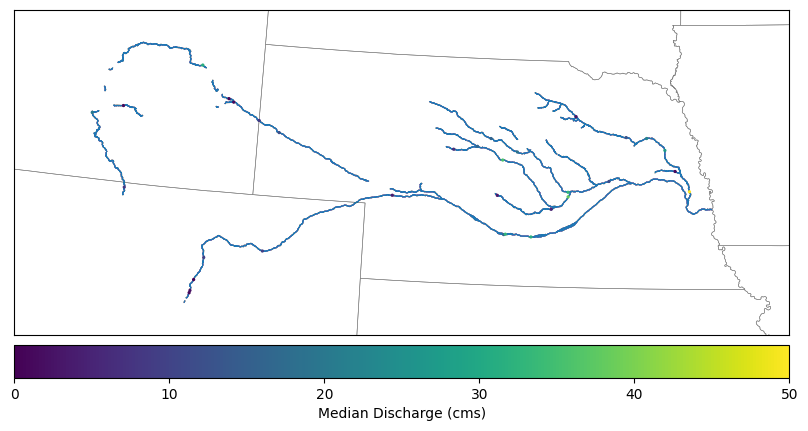

In [ ]:
# gage map

l, b, r, t = centerline.total_bounds


fig, ax = plt.subplots(figsize=(10, 6))

states.plot(ax=ax, facecolor='none', edgecolor='tab:gray', linewidth=0.4, zorder=1)
centerline.plot(ax=ax, color='tab:blue', zorder=2, linewidth=0.8)
gQ = gage_pts_map.plot(ax=ax, column='Q_cms', cmap='viridis', zorder=3, legend=False, markersize=1.8)

sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=50))
sm.set_array([])


divider = make_axes_locatable(ax)
cbar_ax = divider.append_axes('bottom', size='10%', pad=0.1)
plt.colorbar(sm, label='Median Discharge (cms)', cax=cbar_ax, orientation='horizontal')

ax.set_xlim((l - (r - l) / 8), (r + (r - l) / 8))
ax.set_ylim((b - (t - b) / 8), (t + (t - b) / 8))

ax.set_xticks([])
ax.set_yticks([])

fig.savefig('/content/drive/MyDrive/Platte_gage_map_hires_20250929.png', dpi=600, bbox_inches='tight')

Load in-situ widths from USGS

In [ ]:
width_dfs = []
for gage in set(gage_list):
    url = f'https://api.waterdata.usgs.gov/samples-data/results/fullphyschem?mimeType=text%2Fcsv&monitoringLocationIdentifier=USGS-{gage}&characteristicGroup=Physical&characteristicUserSupplied=Width%20of%20stream'

    tempdf = pd.read_csv(url)

    ws = tempdf[['Location_Identifier', 'Activity_StartDate', 'Result_Measure']]
    width_dfs.append(tempdf)

isw = pd.concat(width_dfs)

isw['site_no'] = isw.apply(lambda x: x['Location_Identifier'].split('-')[1], axis=1)
isw = isw.rename(columns={'Activity_StartDate': 'date', 'Result_Measure': 'width_ft'})
isw['date'] = isw.apply(lambda x: datetime.date(int(x['date'].split('-')[0]), int(x['date'].split('-')[1]), int(x['date'].split('-')[2])), axis=1)
isw['gage_width_m'] = isw.width_ft / 3.28
isw = isw[['date', 'gage_width_m', 'site_no']].set_index(['site_no', 'date'])
isw

gage_width_m
site_no  date                    
06775900 2021-05-26     15.853659
         2016-11-16     11.585366
         2016-08-17     11.585366
         2017-06-14     15.853659
         2019-08-21     14.024390
...                           ...
06805500 2025-07-16    378.048780
         2025-08-12    378.048780
         2025-08-27    378.048780
         2025-07-31    378.048780
         2025-08-12    378.048780

[1237 rows x 1 columns]

Pair gage ids with effective width point ids

In [ ]:
gage_list = ['06801000','06801000','06801000',
             '06800500','06800500','06800500',
             '06805500','06805500','06805500',
             '06800000','06800000','06800000',
             '06775900','06775900','06775900',
             '06620000','06620000','06620000']

points = [201625, # 06801000
          153085,
          201888,
          246043, # 06800500
          246016,
          246048,
          202726, # 06805500
          203066,
          202446,
          120725, # 06800000
          120445,
          120748,
          94011, # 06775900
          93932,
          94005,
          41913, # 06620000
          41900,
          41930]


gage_pts = pd.DataFrame({'gage_id': gage_list,
                         'iindex': points})

u_gage_list = []
for g in set(gage_list):
    u_gage_list.append(g)

gage_pts = pd.merge(gage_pts, gpd.read_file('/content/drive/MyDrive/river_tinder_assets/gage_sites/gage_circles_3x_20250909.shp'), how='outer', on='iindex')[['gage_id', 'iindex', 'riv_length']]
gage_pts

,gage_id,iindex,riv_length
0,06620000,41900,140.711919
1,06620000,41913,142.907272
2,06620000,41930,86.932041
3,06775900,93932,96.207959
4,06775900,94005,140.444539
5,06775900,94011,72.135208
6,06800000,120445,76.595306
7,06800000,120725,148.276448
8,06800000,120748,64.253559
9,06801000,153085,2096.250518


Import likes and dislikes from river tinder

In [ ]:

def flatten(xss):
    return [x for xs in xss for x in xs]



checked_img_path = '/content/drive/MyDrive/effwidth_results/rt_likes_dislikes'
lols = []
for fn in tqdm(glob.glob(os.path.join(checked_img_path, 'likes*.txt'))):
    with open(fn, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    lols.append(lines)

lods = []
for fn in tqdm(glob.glob(os.path.join(checked_img_path, 'dislikes*.txt'))):
    with open(fn, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    lods.append(lines)


lols = flatten(lols)
lods = flatten(lods)

lds = pd.DataFrame({'name': lols + lods})
lds['iindex'] = lds.apply(lambda x: int(x['name'][25:]), axis=1)
lds['img_id'] = lds.apply(lambda x: str(x['name'][0:24]), axis=1)
lds['like'] = (np.concatenate([np.repeat(True, len(lols)), np.repeat(False, len(lods))], axis=0))

lds

100%|██████████| 28/28 [00:00<00:00, 212.21it/s]


,name,iindex,img_id,like
0,S2A_14TQL_20240930_0_L2A_201625,201625,S2A_14TQL_20240930_0_L2A,True
1,S2A_15TTF_20240930_0_L2A_153085,153085,S2A_15TTF_20240930_0_L2A,True
2,S2A_15TTF_20240930_0_L2A_202726,202726,S2A_15TTF_20240930_0_L2A,True
3,S2A_15TTF_20240930_0_L2A_203066,203066,S2A_15TTF_20240930_0_L2A,True
4,S2A_15TTF_20240930_0_L2A_202446,202446,S2A_15TTF_20240930_0_L2A,True
...,...,...,...,...
1691,S2A_14TQL_20240913_0_L2A_202726,202726,S2A_14TQL_20240913_0_L2A,False
1692,S2A_14TQL_20240913_0_L2A_203066,203066,S2A_14TQL_20240913_0_L2A,False
1693,S2A_14TQL_20240913_0_L2A_202446,202446,S2A_14TQL_20240913_0_L2A,False
1694,S2A_14TQL_20240913_0_L2A_201888,201888,S2A_14TQL_20240913_0_L2A,False


Join in-situ width and discharge to build rating curves

In [ ]:
cotemporal_wQ = Q.join(isw, how='inner', on=['site_no', 'date'])
cotemporal_wQ = cotemporal_wQ.loc[cotemporal_wQ.gage_width_m != 0]
cotemporal_wQ['logw'] = np.log10(cotemporal_wQ.gage_width_m)
cotemporal_wQ['logQ'] = np.log10(cotemporal_wQ.Q_cms)
cotemporal_wQ

Q_cms  Q_cd       d_m d_cd  gage_width_m      logw  \
site_no  date                                                                  
06620000 2011-08-22   11.392119     A       NaN  NaN     46.951220  1.671647   
         2011-10-12    6.206155     A       NaN  NaN     46.951220  1.671647   
         2012-01-30    3.825712  A, e       NaN  NaN     39.634146  1.598070   
         2012-03-30   17.173195     A       NaN  NaN     47.865854  1.680026   
         2012-06-22    4.279129     A       NaN  NaN     37.804878  1.577548   
...                         ...   ...       ...  ...           ...       ...   
06805500 2025-07-16  250.229883     P  1.161585    P    378.048780  2.577548   
         2025-07-31  368.401866     P  1.329268    P    378.048780  2.577548   
         2025-08-12  253.347129     P  1.164634    P    378.048780  2.577548   
         2025-08-12  253.347129     P  1.164634    P    378.048780  2.577548   
         2025-08-27  121.856002     P  0.865854    P    378.048780  2.577548   

                         logQ  
site_no  date                  
06620000 2011-08-22  1.056605  
         2011-10-12  0.792823  
         2012-01-30  0.582712  
         2012-03-30  1.234851  
         2012-06-22  0.631355  
...                       ...  
06805500 2025-07-16  2.398339  
         2025-07-31  2.566322  
         2025-08-12  2.403716  
         2025-08-12  2.403716  
         2025-08-27  2.085847  

[1222 rows x 7 columns]

Text(0.02, 0.5, 'Gage width (m)')

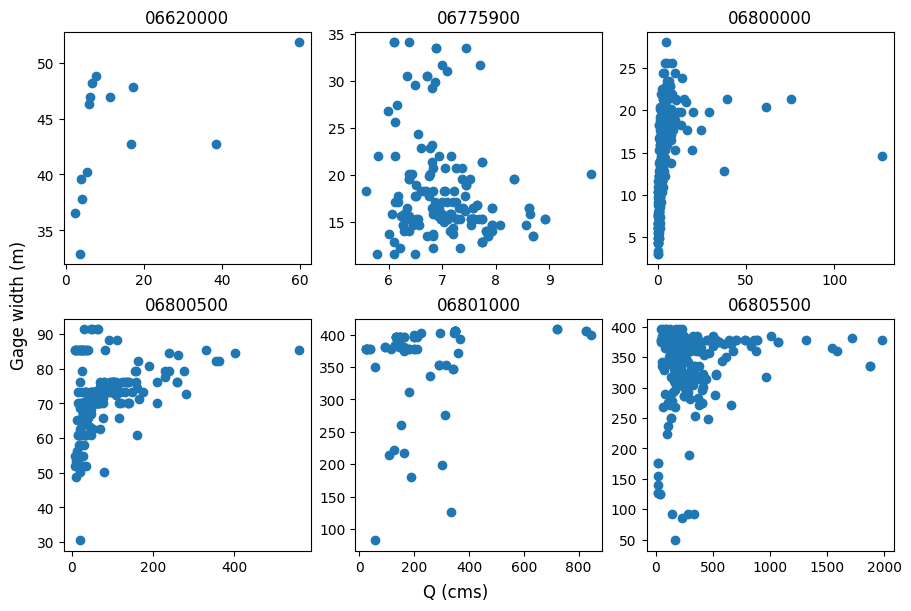

In [ ]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(9, 6), constrained_layout=True)

p = 0
for sn, df in cotemporal_wQ.groupby('site_no'):
    ax = axs.flatten()[p]

    ax.scatter(df.Q_cms, df.gage_width_m)
    ax.set_title(sn)
    p += 1

fig.supxlabel('Q (cms)')
fig.supylabel('Gage width (m)')

Build power law rating curves with cotemporal gage w and Q

Text(0.5, 0.98, 'Power law w/Q rating curves')

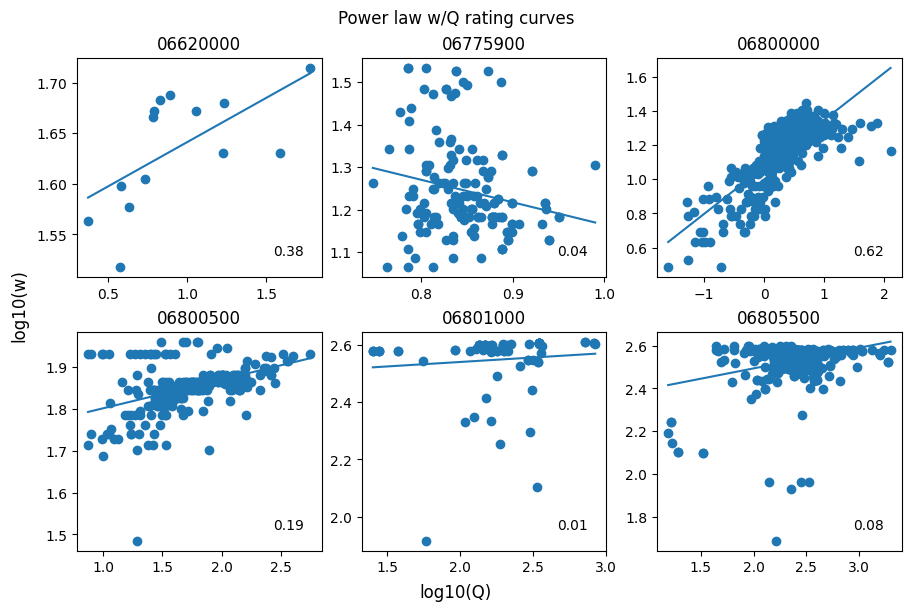

In [ ]:
rc_slopes = []
rc_intercepts = []
r2s = []


fig, (axs) = plt.subplots(ncols=3, nrows=2, figsize=(9, 6), constrained_layout=True)
p = 0
for sn, df in cotemporal_wQ.groupby('site_no'):

    slope, intercept, r, pval, _ = linregress(df.logQ, df.logw)

    rc_slopes.append(slope)
    rc_intercepts.append(intercept)
    r2s.append(r ** 2)

    ax = axs.flatten()[p]
    ax.scatter(df.logQ, df.logw)
    ax.set_title(sn)
    rc_x = np.linspace(min(df.logQ), max(df.logQ))

    ax.plot(rc_x, rc_x * slope + intercept)
    ax.text(0.8, 0.1, f'{round(r ** 2, 2)}', transform=ax.transAxes)
    p += 1

fig.supxlabel('log10(Q)')
fig.supylabel('log10(w)')
fig.suptitle('Power law w/Q rating curves')

In [ ]:
rating_curve_parms = pd.DataFrame({'site_no': u_gage_list, 'b': rc_slopes, 'loga': rc_intercepts, 'r2': r2s}).set_index('site_no')
rating_curve_parms['a'] = 10 ** rating_curve_parms.loga
rating_curve_parms

,b,loga,r2,a
site_no,,,,
06775900,0.087846,1.553382,0.383412,35.758761
06800500,-0.528364,1.692555,0.042450,49.266824
06800000,0.275465,1.072609,0.616782,11.819760
06620000,0.068638,1.732994,0.186642,54.074626
06801000,0.031141,2.477969,0.008993,300.585898
06805500,0.096246,2.301079,0.079128,200.022788


Estimate width from rating curve, full join with in-situ widths on date and gage id

In [ ]:
def est_width(row, site_no):
    a = rating_curve_parms.loc[site_no, 'a']
    b = rating_curve_parms.loc[site_no, 'b']
    Q = row['Q_cms']

    return a * (Q ** b)

Q['rc_width_m'] = Q.apply(lambda row: est_width(row, row.name[0]), axis=1)
Q = Q.join(isw, how='outer', on=['site_no', 'date'])
Q

Q_cms  Q_cd       d_m d_cd  rc_width_m  gage_width_m
site_no  date                                                                 
06620000 2007-11-19    3.967405     A       NaN  NaN   59.439310           NaN
         2007-11-20    3.740696     A       NaN  NaN   59.199738           NaN
         2007-11-21    3.485648  A, e       NaN  NaN   58.913488           NaN
         2007-11-22    3.230601  A, e       NaN  NaN   58.607024           NaN
         2007-11-23    2.862199  A, e       NaN  NaN   58.121987           NaN
...                         ...   ...       ...  ...         ...           ...
06805500 2025-09-18  244.278776     P  1.143293    P  339.550623           NaN
         2025-09-19  273.184153     P  1.198171    P  343.225218           NaN
         2025-09-20  267.799818     P  1.189024    P  342.568258           NaN
         2025-09-21  294.721493     P  1.237805    P  345.741181           NaN
         2025-09-22  265.249343     P  1.185976    P  342.252890           NaN

[39304 rows x 6 columns]

Text(0.5, 0.98, 'Rating curve validation')

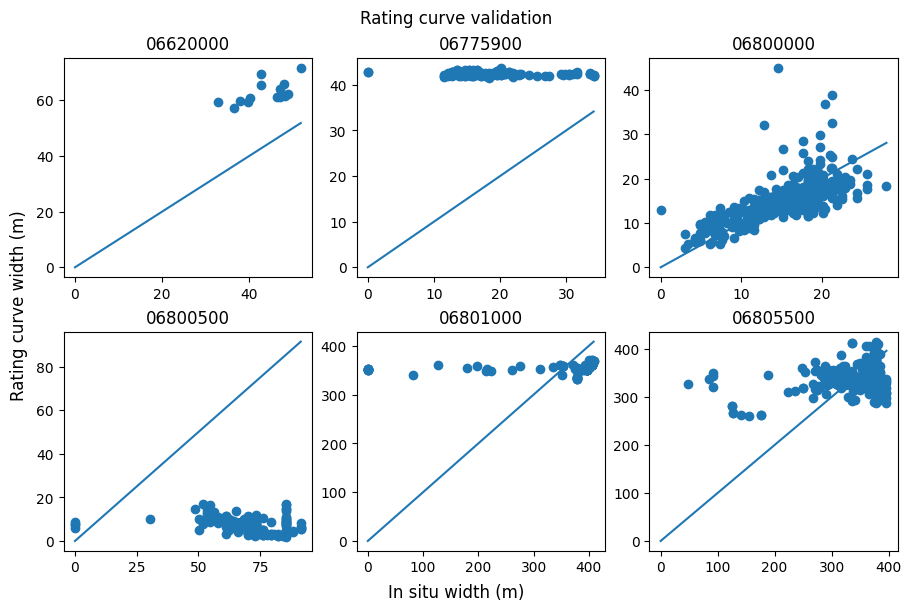

In [ ]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(9, 6), constrained_layout=True)

p = 0
for sn, df in Q.groupby('site_no'):
    ax = axs.flatten()[p]

    ax.scatter(df.gage_width_m, df.rc_width_m)
    unity = np.linspace(0, (df.gage_width_m).max(skipna=True))
    ax.plot(unity, unity)
    ax.set_title(sn)
    # ax.set_xscale('log')
    # ax.set_yscale('log')
    p += 1

fig.supxlabel('In situ width (m)')
fig.supylabel('Rating curve width (m)')
fig.suptitle('Rating curve validation')

How do cotemporal satellite and in-situ widths compare?

Text(0.5, 0.98, 'In-situ vs. satellite width comparison')

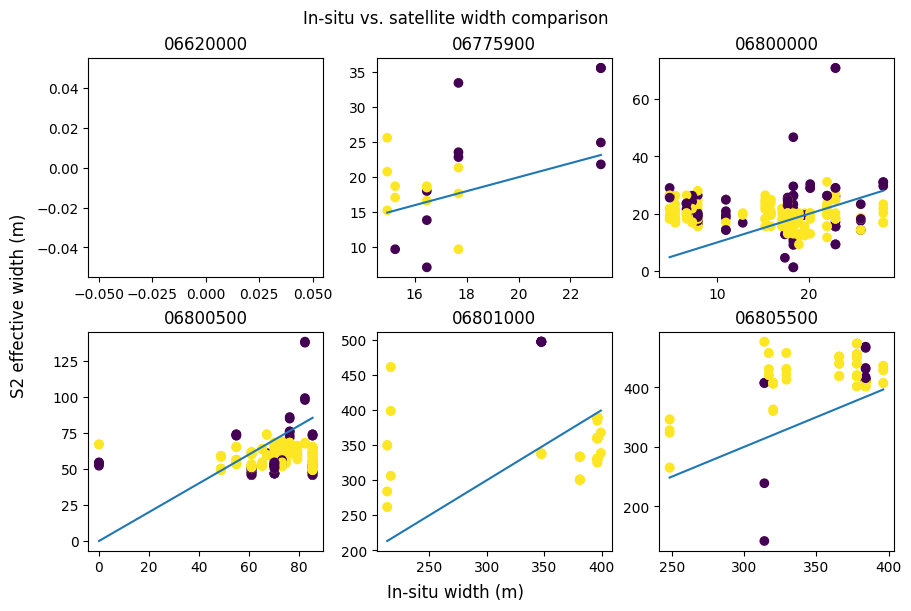

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(9, 6), constrained_layout=True)
p = 0
for g, df in alldata.groupby('site_no'):


    ax = axs.flatten()[p]

    ax.scatter(df.gage_width_m, df.sat_width_m, c=df.like)
    unity = np.linspace(df.gage_width_m.min(), df.gage_width_m.max())
    ax.plot(unity, unity)
    ax.set_title(g)
    p += 1

fig.supxlabel('In-situ width (m)')
fig.supylabel('S2 effective width (m)')
fig.suptitle('In-situ vs. satellite width comparison')